# Decision Trees

# Decision trees: a next step in ML

Decision trees will be our first machine learning (ML) method that builds a classifier in response to data that is distinct from the data.  The final form of this classifier will be a tree.  The interior nodes of the tree store yes or no questions, and the leaves of the tree store classifications.



When classifying, the algorithm starts at the top, asks the first question, and moves left or right as a result of the answer being yes or no.  The questions continue until a leaf is reached, and that is the classification.  There could be many more leaves than possible classifications, which means there can be multiple ways to output the same classification.



Decision trees have the advantage of being inspectable and transparent compared to other methods.  It's easy to say why something was classified.  "That person did not get the loan approved because their income was low and they already declared bankruptcy once."

However, this is also a limitation, as the classifier needs to stick closely to the original features of the dataset when coming up with its rules; it can't come up with new, unintuitive features as easily as a neural network.  We'll explore that idea later.


# Constructing a decision tree - first stump

The decision tree algorithm doesn't create the best possible tree that it could.  Doing so in an efficient amount of time is known to be probably impossible.  Instead, the algorithm is "greedy," a general term for algorithms that just try to do the best-looking thing in the moment, without rethinking earlier decisions.



It's also recursive - the decision tree it makes is equal to the best decision it could make for the root, plus the best possible decision trees for the left and right branches.


We'll focus first on how to pick the best decision possible.  What if we could only make one decision and then had to stop - what decision would we make?



We first should be clear on what kinds of questions are allowed - these are yes or no questions.  This works fine for Boolean (yes or no) features.  But for a categorical feature, like model of car, we could make yes or no question for each model -- "Is it a Camry?  Is it a Corolla?"  And for a numerical feature, we could ask whether an amount is greater than a particular threshold -- "Is the miles per gallon greater than 30?"  While it might seem there are infinitely many thresholds, we can actually just make one per different datapoint value, like putting one at 29.8 if we saw a value like that, because we won't get different answers from the algorithm if we do otherwise.



Next, which of these is the best question to ask?  We want the choice to reduce uncertainty about the classification.  Imagine using the question to separate the training data into two piles, the "answered-yes-to-question" pile and the "answered-no-to-question" pile.  If the whole "answered-yes" pile is consistently labeled "yes" for the classification, that's great - we know the classification with certainty down that road.  And if the other branch says "label-no" for everything as well, then this is a perfect question, removing all uncertainty after classification.



Of course, the world is messier than that, and so there will probably be at least a few labels inconsistent with the majority down each path.  In the worst case, down each branch, the piles of examples are completely jumbled, with equal numbers of "label-yes" and "label-no."  In that case, uncertainty hasn't been reduced at all.



# Entropy

Entropy is a measure of how much "surprise" is possible in a stream of symbols.  When all symbols agree, there's no surprise possible in drawing one at random, and the entropy is 0.  When the symbols are perfectly balanced between two possible symbols, that is the maximum possible entropy for two symbols - you have no idea which one will come next - and the entropy is one.



The formula for entropy is $\sum_i - p_i \log_2 p_i$, where $p_i$ is the frequency of the symbol (ranging from 0 for not appearing to 0.5 appearing half the time, etc).  For our purposes, it's just a metric that is 0 for perfect agreement and 1 for perfect disagreement.




Recall that there are two piles of examples as a result of our sorting into "answered-yes" and "answered-no".  Therefore, there are two entropies.  How to combine them?  We estimate the probability of answering yes and no to the question by counting how many items are in each pile, and then return the value

$\begin{equation}
Pr(yes)Entropy(yes) + Pr(no)Entropy(no)
\end{equation}$



For example, suppose we're trying to predict whether a car gets driven to over 200000 miles, and the feature to evaluate is, "Is it a Toyota Corolla?"  We have 5 examples of Corollas in our database, and they all got driven over 200000 miles.  We have 2000 cars in our database that are not Corollas, and about 20% of them got driven to over 200000 miles.

The entropy for the "yes" branch of the question is 0, and its probability is 5/2005.  The entropy for the "no" branch is -0.2 lg 0.2 - 0.8 lg 0.8, which we can compute in a code box:

In [1]:
import math
-0.2 * math.log(0.2,2) - 0.8 * math.log(0.8, 2)

0.7219280948873623

The probability of going down the not-Corolla branch is 2000/2005, so the overall expected entropy is 

In [2]:
0 * 5/2005 + 0.72 * 2000/2005

0.7182044887780549

If you were to just ask a single question, then asking whether it's a Corolla is not great if most of the cars in your data aren't Corollas.  This was a slight improvement, but the weighting of the non-Corollas is much higher than the weighting of the 0 entropy path.

# Adding recursion

We could just stop there with one question (or "feature").  This is called creating a "decision stump," and it can be useful when combined with other meta-algorithms called ensemble learners.  But the decision tree algorithm recursively creates more branches down the left and right sides.

Separating the data into two piles creates two recursive problems:  find the best subtree on the left, and find the best subtree on the right.  As long as there's disagreement among the examples about the label, we run the decision tree question-picking subroutine to find the best way to split the pile of examples.

If the examples all agree at a node, we stop and don't create another question for this node; instead, make a leaf.  All the examples agreed, so that's a good classification.



It's also possible, because real data is inconsistent, that the algorithm runs out of questions that help at all.  The entropy may not drop if there's no question that actually helps answer the classification problem.  So we also need to check whether the best question choice actually helped, and if it didn't, stop and create a leaf with the majority label instead.



We can continue our car example.  Suppose the Corolla feature really was the best feature we could find.  The Corolla-yes examples all agreed with each other, so we don't need to recur for those -- they're a leaf.  But for the other examples, we run through all possible questions, and one is "Is it a Honda Fit?"  There are 10/2000 yes examples, of which 9/10 make it to 200,000 miles on the odometer, leaving the remaining "answered no" pile with 391/1990 "labeled yes" examples.  We calculate the expected entropy:

In [3]:
391/1990 # Probability of yes classification among not-Fit cars

0.1964824120603015

In [4]:
1 - 391/1990

0.8035175879396985

In [5]:
import math
10/2000 * (-0.1 * math.log(0.1,2) - 0.9 * math.log(0.9,2)) + \
1990/2000 * (-0.20 * math.log(0.20,2) - 0.80 * math.log(0.80))

0.6420309356966424

Suppose that feature is chosen - then both branches could be recursively split, with the Fit branch needing one more question to determine why the 1 in 10 Fits didn't get to 100,000 miles, and the non-Fit branch still having a ways to go to carve off meaningful categories of vehicles.

# Using Decision Trees in scikit-learn

Decision trees are another AI technique you can use in scikit-learn.  fit(), predict(), and score() all work the way you'd expect.

The dataset is a classic statistical dataset, classifying iris flowers from four anatomical features.

In [1]:
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
import numpy as np

iris = load_iris()

In [2]:
iris["feature_names"]

['sepal length (cm)',
 'sepal width (cm)',
 'petal length (cm)',
 'petal width (cm)']

In [3]:
iris["target_names"]

array(['setosa', 'versicolor', 'virginica'], dtype='<U10')

In [4]:
iris.data[0]

array([5.1, 3.5, 1.4, 0.2])

Since the features are numerical, decision tree learning will try every possible split at values observed in the data.

In [5]:
features_train, features_test, labels_train, labels_test = \
train_test_split(iris['data'], iris['target'], test_size=0.1)

In [6]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score

dtree = DecisionTreeClassifier(criterion="entropy", random_state=110)
dtree.fit(features_train, labels_train)
dtree.score(features_test, labels_test) # Gives accuracy_

0.9333333333333333

An advantage of decision trees is that we can easily see their representation - although they get complex fast!

[Text(234.36, 504.7714285714286, 'petal width (cm) <= 0.8\nentropy = 1.583\nsamples = 135\nvalue = [43, 48, 44]\nclass = versicolor'),
 Text(156.24, 427.11428571428576, 'entropy = 0.0\nsamples = 43\nvalue = [43, 0, 0]\nclass = setosa'),
 Text(312.48, 427.11428571428576, 'petal length (cm) <= 4.75\nentropy = 0.999\nsamples = 92\nvalue = [0, 48, 44]\nclass = versicolor'),
 Text(234.36, 349.4571428571429, 'entropy = 0.0\nsamples = 42\nvalue = [0, 42, 0]\nclass = versicolor'),
 Text(390.6, 349.4571428571429, 'petal width (cm) <= 1.75\nentropy = 0.529\nsamples = 50\nvalue = [0, 6, 44]\nclass = virginica'),
 Text(156.24, 271.8, 'petal length (cm) <= 4.95\nentropy = 0.991\nsamples = 9\nvalue = [0, 5, 4]\nclass = versicolor'),
 Text(78.12, 194.14285714285717, 'entropy = 0.0\nsamples = 3\nvalue = [0, 3, 0]\nclass = versicolor'),
 Text(234.36, 194.14285714285717, 'petal width (cm) <= 1.55\nentropy = 0.918\nsamples = 6\nvalue = [0, 2, 4]\nclass = virginica'),
 Text(156.24, 116.48571428571432, 'en

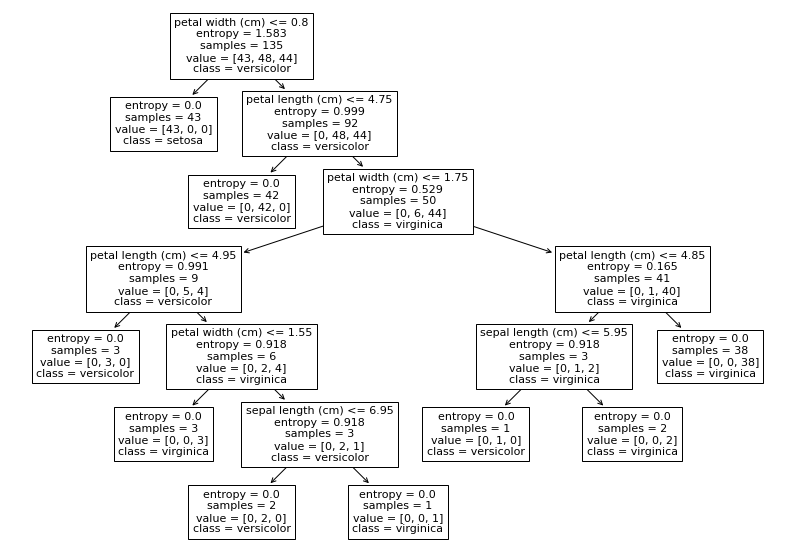

In [12]:
import matplotlib.pyplot as plt
from sklearn import tree

plt.figure(figsize=(14,10))
tree.plot_tree(dtree, feature_names = iris["feature_names"], class_names = iris["target_names"])

# Overfitting

It's possible for decision trees to overfit to the data, creating hypotheses that agree with the training data, but not the test data.  An example of an absurd rule would be to classify anybody named "Simon" as unworthy of a loan, because there one person in the training data named "Simon" who shouldn't get a loan.  A car classifier with license plates as a feature could have a similar problem.  Basically, any very specific patterns that can be found in training run the risk of being useless or worse during testing.



There are a variety of things you can do to counter overfitting.  One is the time-intensive trial-and-error pruning:  collapse two leaves to be the same leaf, check whether validation performance improved, repeat.  Russell and Norvig, the AI textbook, suggests trying a statistical test for each node (a chi-square test) to determine whether the relationship between feature and label is statistically significant.  And scikit-learn comes with a variety of optional arguments:  create a max depth, require a minimum information gain to prune, and so on.  There's no one way to fight overfitting, but it's a good idea to do so on any more complex dataset.